In [1]:
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h, make_extended_predictor_matrix

cc = np.concatenate

TARG = 'G2'

# EXPT = 'ASENSORY_AZ'
# EXPT = 'CL_360_LOWFLOW_ACV'
EXPT = 'CL_180_HighFlow_ACV'

MVNG_ONLY = True

COLORS = {
    'G2': 'b', 'G3': 'r', 'G4': 'g', 'G5': 'm',
    'Motion': 'k', 'ForVel': 'k', 'AngVel': 'k', 'AbsAngVel': 'k',
}

T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

SRCS = ['ForVel', 'AbsAngVel', 'Motion']
DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

N_NAN_INTER = int(round(1.1 * (T_WDW[1] - T_WDW[0]) / DT))

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'DAN_FROM_BEHAV_FILTERS_AGG')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    
if MVNG_ONLY:
    SFX = '_MVNG_ONLY'
else:
    SFX = ''

# Load data and normalize/mask

In [2]:
if EXPT == 'ASENSORY_AZ':
    base = 'BigMAT.csv'
    mvng = 'Moving_Bouts.csv'
    mvng_cols = ['T1', 'T2']
else:
    base = 'clean.csv'
    mvng = 'moving.csv'
    mvng_cols = ['Start', 'Stop']
    
trls = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trl in os.listdir(fly_path):
        trl_path = os.path.join(fly_path, trl)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trl_path, base))
        
        # select relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion', 'ForVel', 'AngVel']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        if MVNG_ONLY:
            t_mask = np.zeros(len(data_u_), dtype=bool)
            
            if not os.path.exists(os.path.join(trl_path, mvng)):
                continue
                
            df_mvng = pd.read_csv(os.path.join(trl_path, mvng))
            
            for start, stop in zip(df_mvng[mvng_cols[0]], df_mvng[mvng_cols[1]]):
                t_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
                
            # TODO: create t_mask by opening moving bouts file
            data_u_[~t_mask] = np.nan
            
        data_u[trl] = data_u_
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_ -= data_n_.mean()
        data_n_ /= data_n_.std()
        
        # replace normalized time column with original time column
        data_n_['Time'] = data_u_['Time']
        
        data_n[trl] = data_n_
        
        trls.append(trl)

# Fit filters on aggregated data

In [3]:
np.random.seed(0)

# aggregate data by concatenating all trials interleaved with 10-sec nan chunks
n_trn = int(round(.8*len(trls)))
n_tst = len(trls) - n_trn

# randomly select training/test trials
idxs_rnd = np.random.permutation(len(trls))

trls_trn = np.array(trls)[idxs_rnd[:n_trn]]
trls_tst = np.array(trls)[idxs_rnd[n_trn:n_trn+n_tst]]

targ_trn = cc([cc([np.array(data_n[trl][TARG]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_trn])
srcs_trn = {
    src: cc([cc([np.array(data_n[trl][src]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_trn])
    for src in SRCS
}

targ_tst = cc([cc([np.array(data_n[trl][TARG]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_tst])
srcs_tst = {
    src: cc([cc([np.array(data_n[trl][src]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_tst])
    for src in SRCS
}

# int filter windows
t_h = np.arange(*T_WDW, DT)
wdws_d = [None, None]
wdws_d[0] = int(round(T_WDW[0]/DT))
wdws_d[1] = wdws_d[0] + int(len(t_h))

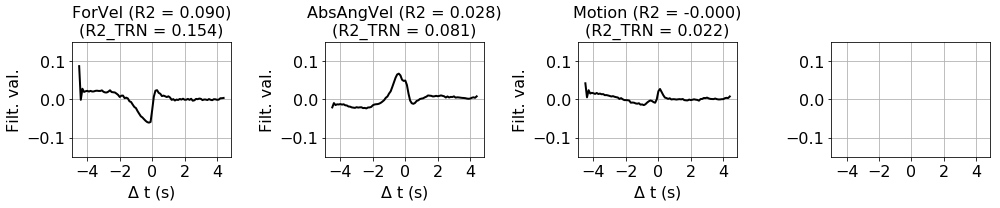

In [4]:
# individual filters
hs_indiv = {}
icpts_indiv = {}
y_hat_trn_indiv = {}
r2_trn_indiv = {}

y_hat_tst_indiv = {}
r2_tst_indiv = {}

for src in SRCS:
    xs_trn = {src: srcs_trn[src]}
    y_trn = targ_trn
    
    hs, icpt, y_hat_trn, r2_trn, model = fit_h(
        xs_trn, y_trn, {src: wdws_d}, [src],
        'built-in', params={'model': linear_model.LinearRegression}, return_model=True)
    
    n = np.sum(~np.isnan(y_hat_trn))
    
    hs_indiv[src] = hs[src].copy()
    icpts_indiv[src] = icpt
    
    y_hat_trn_indiv[src] = y_hat_trn.copy()
    r2_trn_indiv[src] = r2_trn
    
    # compute test r2
    ## get test predictos and target
    xs_tst = {src: srcs_tst[src]}
    y_tst = targ_tst
    
    ## make test set extended predictor matrix
    x_xtd_tst = make_extended_predictor_matrix(vs=xs_tst, windows={src: wdws_d}, order=[src])
    
    ## get test set predictions
    valid = np.all(~np.isnan(x_xtd_tst), axis=1) & (~np.isnan(y_tst))
    y_hat_tst = np.nan * np.zeros(len(y_tst))
    y_hat_tst[valid] = model.predict(x_xtd_tst[valid])
    
    ## compute r2
    r2_tst = model.score(x_xtd_tst[valid], y_tst[valid])
    r2_tst_indiv[src] = r2_tst
    
# plot indiv filters
fig, axs = plt.subplots(1, 4, figsize=(14, 3), sharex=True, tight_layout=True)
for src, ax in zip(SRCS, axs):
    ax.plot(t_h, hs_indiv[src], c=COLORS[src], lw=2)
    
    ax.set_xlabel('$\Delta$ t (s)')
    ax.set_ylabel('Filt. val.')
    ax.set_title('{0} (R2 = {1:.3f})\n(R2_TRN = {2:.3f})'.format(src, r2_tst_indiv[src], r2_trn_indiv[src]))
    
for ax in axs:
    ax.set_ylim(-.15, .15)
    ax.grid()
    set_font_size(ax, 16)
    
# save fig
fig.savefig(os.path.join(SAVE_DIR, 'FILTERS_SINGLE_{}_{}{}.pdf'.format(EXPT, TARG.upper(), SFX)), dpi=300)

# save CSV
data = []
time_cols = list(['{0:.3f}'.format(t_h_) for t_h_ in t_h])
for src in SRCS:
    data_ = {'DAN': src, 'R2': r2_tst_indiv[src]}
    for ctr, time_col in enumerate(time_cols):
        data_[time_col] = hs_indiv[src][ctr]
    data.append(data_)
    
cols = ['DAN', 'R2'] + time_cols
df = pd.DataFrame(data=data, columns=cols)
df.to_csv(os.path.join(SAVE_DIR, 'FILTERS_SINGLE_{}_{}{}.csv'.format(EXPT, TARG.upper(), SFX)), index=False)

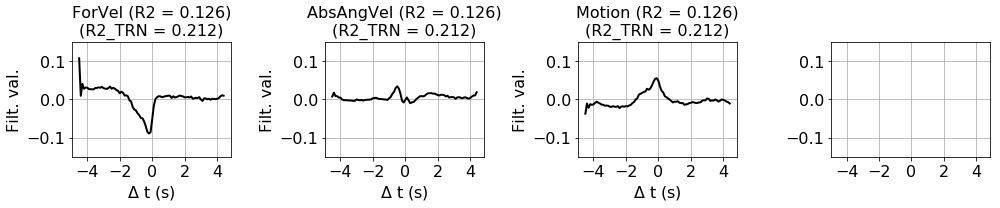

In [5]:
# filters on all DANs
xs_trn_mlt = srcs_trn
y_trn = targ_trn

hs_mlt, icpt_mlt, y_hat_trn_mlt, r2_trn_mlt, model_mlt = fit_h(
    xs_trn_mlt, y_trn, {src: wdws_d for src in SRCS}, SRCS,
    'built-in', params={'model': linear_model.LinearRegression}, return_model=True)

n = np.sum(~np.isnan(y_hat_trn_mlt))

# compute test r2
## get test predictions and target
xs_tst_mlt = srcs_tst
y_tst = targ_tst

## make test set extended predictor matrix
x_xtd_tst_mlt = make_extended_predictor_matrix(vs=xs_tst_mlt, windows={src: wdws_d for src in SRCS}, order=SRCS)

## get test set predictions
valid = np.all(~np.isnan(x_xtd_tst_mlt), axis=1) & (~np.isnan(y_tst))
y_hat_tst_mlt = np.nan * np.zeros(len(y_tst))
y_hat_tst_mlt[valid] = model_mlt.predict(x_xtd_tst_mlt[valid])

## compute r2
r2_tst_mlt = model_mlt.score(x_xtd_tst_mlt[valid], y_tst[valid])

# plot full filters
fig, axs = plt.subplots(1, 4, figsize=(14, 3), sharex=True, tight_layout=True)
for src, ax in zip(SRCS, axs):
    ax.plot(t_h, hs_mlt[src], c=COLORS[src], lw=2)
    
    ax.set_xlabel('$\Delta$ t (s)')
    ax.set_ylabel('Filt. val.')
    ax.set_title('{0} (R2 = {1:.3f})\n(R2_TRN = {2:.3f})'.format(src, r2_tst_mlt, r2_trn_mlt))
    
for ax in axs:
    ax.set_ylim(-.15, .15)
    ax.grid()
    set_font_size(ax, 16)
    
# save fig
fig.savefig(os.path.join(SAVE_DIR, 'FILTERS_MULTI_{}_{}{}.pdf'.format(EXPT, TARG.upper(), SFX)), dpi=300)

# save CSV
data = []
time_cols = list(['{0:.3f}'.format(t_h_) for t_h_ in t_h])
for src in SRCS:
    data_ = {'DAN': src, 'R2': r2_tst_mlt}
    for ctr, time_col in enumerate(time_cols):
        data_[time_col] = hs_mlt[src][ctr]
    data.append(data_)
    
cols = ['DAN', 'R2'] + time_cols
df = pd.DataFrame(data=data, columns=cols)
df.to_csv(os.path.join(SAVE_DIR, 'FILTERS_MULTI_{}_{}{}.csv'.format(EXPT, TARG.upper(), SFX)), index=False)

## Loop over training/test splits

In [6]:
r2s_trn_indiv = {src: [] for src in SRCS}
r2s_tst_indiv = {src: [] for src in SRCS}

r2s_trn_mlt = []
r2s_tst_mlt = []


for seed in range(50):
    print('seed', seed, '...')
    
    # preparation
    np.random.seed(seed)

    ## aggregate data by concatenating all trials interleaved with 10-sec nan chunks
    n_trn = int(round(.8*len(trls)))
    n_tst = len(trls) - n_trn

    ## randomly select training/test trials
    idxs_rnd = np.random.permutation(len(trls))

    trls_trn = np.array(trls)[idxs_rnd[:n_trn]]
    trls_tst = np.array(trls)[idxs_rnd[n_trn:n_trn+n_tst]]

    targ_trn = cc([cc([np.array(data_n[trl][TARG]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_trn])
    srcs_trn = {
        src: cc([cc([np.array(data_n[trl][src]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_trn])
        for src in SRCS
    }

    targ_tst = cc([cc([np.array(data_n[trl][TARG]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_tst])
    srcs_tst = {
        src: cc([cc([np.array(data_n[trl][src]), np.nan * np.zeros(N_NAN_INTER)]) for trl in trls_tst])
        for src in SRCS
    }

    ## int filter windows
    t_h = np.arange(*T_WDW, DT)
    wdws_d = [None, None]
    wdws_d[0] = int(round(T_WDW[0]/DT))
    wdws_d[1] = wdws_d[0] + int(len(t_h))
    
    # individual filters
    hs_indiv = {}
    icpts_indiv = {}
    y_hat_trn_indiv = {}
    r2_trn_indiv = {}

    y_hat_tst_indiv = {}
    r2_tst_indiv = {}

    for src in SRCS:
        xs_trn = {src: srcs_trn[src]}
        y_trn = targ_trn

        hs, icpt, y_hat_trn, r2_trn, model = fit_h(
            xs_trn, y_trn, {src: wdws_d}, [src],
            'built-in', params={'model': linear_model.LinearRegression}, return_model=True)

        n = np.sum(~np.isnan(y_hat_trn))

        hs_indiv[src] = hs[src].copy()
        icpts_indiv[src] = icpt

        y_hat_trn_indiv[src] = y_hat_trn.copy()
        r2_trn_indiv[src] = r2_trn

        ## compute test r2
        ### get test predictos and target
        xs_tst = {src: srcs_tst[src]}
        y_tst = targ_tst

        ### make test set extended predictor matrix
        x_xtd_tst = make_extended_predictor_matrix(vs=xs_tst, windows={src: wdws_d}, order=[src])

        ### get test set predictions
        valid = np.all(~np.isnan(x_xtd_tst), axis=1) & (~np.isnan(y_tst))
        y_hat_tst = np.nan * np.zeros(len(y_tst))
        y_hat_tst[valid] = model.predict(x_xtd_tst[valid])

        ### compute r2
        r2_tst = model.score(x_xtd_tst[valid], y_tst[valid])
        r2_tst_indiv[src] = r2_tst
        
        ### store train and test r2
        r2s_trn_indiv[src].append(r2_trn)
        r2s_tst_indiv[src].append(r2_tst)

    # multi-DAN filters
    xs_trn_mlt = srcs_trn
    y_trn = targ_trn

    hs_mlt, icpt_mlt, y_hat_trn_mlt, r2_trn_mlt, model_mlt = fit_h(
        xs_trn_mlt, y_trn, {src: wdws_d for src in SRCS}, SRCS,
        'built-in', params={'model': linear_model.LinearRegression}, return_model=True)

    n = np.sum(~np.isnan(y_hat_trn_mlt))

    # compute test r2
    ## get test predictions and target
    xs_tst_mlt = srcs_tst
    y_tst = targ_tst

    ## make test set extended predictor matrix
    x_xtd_tst_mlt = make_extended_predictor_matrix(vs=xs_tst_mlt, windows={src: wdws_d for src in SRCS}, order=SRCS)

    ## get test set predictions
    valid = np.all(~np.isnan(x_xtd_tst_mlt), axis=1) & (~np.isnan(y_tst))
    y_hat_tst_mlt = np.nan * np.zeros(len(y_tst))
    y_hat_tst_mlt[valid] = model_mlt.predict(x_xtd_tst_mlt[valid])

    ## compute r2
    r2_tst_mlt = model_mlt.score(x_xtd_tst_mlt[valid], y_tst[valid])
    
    ## store train and test r2
    r2s_trn_mlt.append(r2_trn_mlt)
    r2s_tst_mlt.append(r2_tst_mlt)

seed 0 ...
seed 1 ...
seed 2 ...
seed 3 ...
seed 4 ...
seed 5 ...
seed 6 ...
seed 7 ...
seed 8 ...
seed 9 ...
seed 10 ...
seed 11 ...
seed 12 ...
seed 13 ...
seed 14 ...
seed 15 ...
seed 16 ...
seed 17 ...
seed 18 ...
seed 19 ...
seed 20 ...
seed 21 ...
seed 22 ...
seed 23 ...
seed 24 ...
seed 25 ...
seed 26 ...
seed 27 ...
seed 28 ...
seed 29 ...
seed 30 ...
seed 31 ...
seed 32 ...
seed 33 ...
seed 34 ...
seed 35 ...
seed 36 ...
seed 37 ...
seed 38 ...
seed 39 ...
seed 40 ...
seed 41 ...
seed 42 ...
seed 43 ...
seed 44 ...
seed 45 ...
seed 46 ...
seed 47 ...
seed 48 ...
seed 49 ...


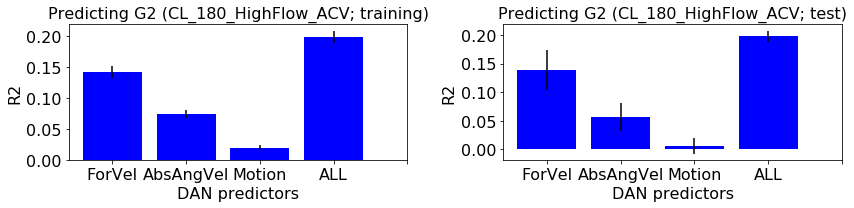

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3), tight_layout=True)

# indiv
for ctr, src in enumerate(SRCS):
    ## train
    mean = np.mean(r2s_trn_indiv[src])
    std = np.std(r2s_trn_indiv[src])
    axs[0].bar([ctr], [mean], yerr=[std], color='b')
    ## test
    mean = np.mean(r2s_tst_indiv[src])
    std = np.std(r2s_tst_indiv[src])
    axs[1].bar([ctr], [mean], yerr=[std], color='b')
    
# mlt
## train
mean = np.mean(r2s_trn_mlt)
std = np.std(r2s_trn_mlt)
axs[0].bar([len(SRCS)], [mean], yerr=[std], color='b')
## test
mean = np.mean(r2s_trn_mlt)
std = np.std(r2s_trn_mlt)
axs[1].bar([len(SRCS)], [mean], yerr=[std], color='b')

axs[0].set_title('Predicting {} ({}; training)'.format(TARG, EXPT))
axs[1].set_title('Predicting {} ({}; test)'.format(TARG, EXPT))

for ax in axs:
    ax.set_xticks(range(5))
    ax.set_xticklabels(SRCS + ['ALL'])
    ax.set_xlabel('DAN predictors')
    ax.set_ylabel('R2')
    set_font_size(ax, 16)
    
# save fig
fig.savefig(os.path.join(SAVE_DIR, 'R2_{}_{}{}.pdf'.format(EXPT, TARG.upper(), SFX)), dpi=300)

# save CSV
cols = ['PREDICTORS'] + ['TRIAL_{}'.format(ctr) for ctr in range(len(r2s_tst_mlt))]
data = []
for src in SRCS:
    data_ = {'PREDICTORS': src}
    for ctr, r2 in enumerate(r2s_tst_indiv[src]):
        data_['TRIAL_{}'.format(ctr)] = r2
    data.append(data_)
data_ = {'PREDICTORS': 'ALL'}
for ctr, r2 in enumerate(r2s_tst_mlt):
    data_['TRIAL_{}'.format(ctr)] = r2
data.append(data_)
df = pd.DataFrame(data=data, columns=cols)
df.to_csv(os.path.join(SAVE_DIR, 'R2_{}_{}{}.csv'.format(EXPT, TARG.upper(), SFX)), index=False)